In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import pickle
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

print("🎯 ULTIMATE 85%+ CRICKET MATCH PREDICTOR")
print("="*70)

matches = pd.read_csv('../data/processed/quality_matches_dataset.csv')

print(f"\n✅ Loaded {len(matches)} quality matches")
print(f"📊 Formats: {dict(matches['match_format'].value_counts())}")
print(f"🌍 Venues: {matches['venue'].nunique()}")
print(f"🏏 Teams: {pd.concat([matches['team1'], matches['team2']]).nunique()}")

matches.head()

🎯 ULTIMATE 85%+ CRICKET MATCH PREDICTOR

✅ Loaded 7513 quality matches
📊 Formats: {'T20': np.int64(3599), 'ODI': np.int64(2778), 'IPL': np.int64(1136)}
🌍 Venues: 557
🏏 Teams: 125


,match_format,venue,season,team1,team2,team1_runs,team1_wickets,team1_run_rate,team1_boundaries,team1_fours,team1_sixes,team2_runs,team2_wickets,team2_run_rate,team2_boundaries,team2_fours,team2_sixes,run_difference,team1_won,winner
0,T20,Melbourne Cricket Ground,2016/17,Australia,Sri Lanka,168,6,8.06,13,9,4,172,5,8.26,21,20,1,4,0,Sri Lanka
1,T20,"Simonds Stadium, South Geelong",2016/17,Australia,Sri Lanka,173,10,8.44,16,10,6,176,8,8.52,24,18,6,3,0,Sri Lanka
2,T20,Adelaide Oval,2016/17,Australia,Sri Lanka,187,6,8.98,22,14,8,146,10,7.62,17,12,5,41,1,Australia
3,T20,"Bready Cricket Club, Magheramason",2016,Hong Kong,Ireland,169,5,7.92,18,13,5,129,10,6.40,14,12,2,40,1,Hong Kong
4,T20,Harare Sports Club,2016,Zimbabwe,India,170,7,8.23,21,11,10,168,6,7.81,19,13,6,2,1,Zimbabwe


In [4]:
print("🔧 Engineering ADVANCED Features for 85%+ Accuracy...")
print("="*70)

# 1. TEAM HISTORICAL PERFORMANCE
print("\n1️⃣ Calculating team historical performance...")
team_stats = {}

for team in pd.concat([matches['team1'], matches['team2']]).unique():
    t1_matches = matches[matches['team1'] == team]
    t2_matches = matches[matches['team2'] == team]
    
    # Overall stats
    total_matches = len(t1_matches) + len(t2_matches)
    if total_matches == 0:
        continue
    
    # Wins
    wins_as_t1 = t1_matches['team1_won'].sum()
    wins_as_t2 = len(t2_matches) - t2_matches['team1_won'].sum()
    total_wins = wins_as_t1 + wins_as_t2
    
    # Win rates
    overall_wr = total_wins / total_matches
    bat_first_wr = wins_as_t1 / len(t1_matches) if len(t1_matches) > 0 else 0.5
    chase_wr = wins_as_t2 / len(t2_matches) if len(t2_matches) > 0 else 0.5
    
    # Scoring stats
    avg_score = t1_matches['team1_runs'].mean() if len(t1_matches) > 0 else 150
    avg_rr = t1_matches['team1_run_rate'].mean() if len(t1_matches) > 0 else 6.0
    avg_boundaries = t1_matches['team1_boundaries'].mean() if len(t1_matches) > 0 else 15
    
    team_stats[team] = {
        'overall_win_rate': overall_wr,
        'bat_first_win_rate': bat_first_wr,
        'chase_win_rate': chase_wr,
        'avg_score': avg_score,
        'avg_run_rate': avg_rr,
        'avg_boundaries': avg_boundaries,
        'total_matches': total_matches
    }

# Add team stats to matches
matches['team1_overall_wr'] = matches['team1'].map(lambda x: team_stats.get(x, {}).get('overall_win_rate', 0.5))
matches['team2_overall_wr'] = matches['team2'].map(lambda x: team_stats.get(x, {}).get('overall_win_rate', 0.5))
matches['team1_bat_first_wr'] = matches['team1'].map(lambda x: team_stats.get(x, {}).get('bat_first_win_rate', 0.5))
matches['team2_chase_wr'] = matches['team2'].map(lambda x: team_stats.get(x, {}).get('chase_win_rate', 0.5))
matches['team1_avg_score'] = matches['team1'].map(lambda x: team_stats.get(x, {}).get('avg_score', 150))
matches['team1_avg_rr'] = matches['team1'].map(lambda x: team_stats.get(x, {}).get('avg_run_rate', 6.0))

print(f"   ✅ Calculated stats for {len(team_stats)} teams")

# 2. VENUE INTELLIGENCE (GROUND-SPECIFIC STATS!)
print("\n2️⃣ Calculating venue-specific statistics...")
venue_stats = matches.groupby('venue').agg({
    'team1_runs': ['mean', 'std', 'median'],
    'team1_won': 'mean',
    'team1_run_rate': 'mean',
    'team1_boundaries': 'mean',
    'team1_wickets': 'mean',
    'venue': 'count'
}).reset_index()

venue_stats.columns = ['venue', 'venue_avg_score', 'venue_score_std', 'venue_median_score',
                       'venue_bat_first_advantage', 'venue_avg_rr', 'venue_avg_boundaries',
                       'venue_avg_wickets', 'venue_match_count']

# Merge venue stats
matches = matches.merge(venue_stats, on='venue', how='left')

# Fill missing values with dataset averages
matches['venue_avg_score'].fillna(matches['team1_runs'].mean(), inplace=True)
matches['venue_bat_first_advantage'].fillna(0.5, inplace=True)
matches['venue_avg_rr'].fillna(matches['team1_run_rate'].mean(), inplace=True)
matches['venue_avg_boundaries'].fillna(matches['team1_boundaries'].mean(), inplace=True)

print(f"   ✅ Analyzed {matches['venue'].nunique()} unique venues")

# 3. HEAD-TO-HEAD RECORDS
print("\n3️⃣ Calculating head-to-head records...")
h2h_stats = {}

for idx, row in matches.iterrows():
    t1, t2 = row['team1'], row['team2']
    key = tuple(sorted([t1, t2]))
    
    if key not in h2h_stats:
        h2h_matches = matches[
            ((matches['team1'] == t1) & (matches['team2'] == t2)) |
            ((matches['team1'] == t2) & (matches['team2'] == t1))
        ]
        
        t1_wins = len(h2h_matches[
            ((h2h_matches['team1'] == t1) & (h2h_matches['team1_won'] == 1)) |
            ((h2h_matches['team2'] == t1) & (h2h_matches['team1_won'] == 0))
        ])
        
        total = len(h2h_matches)
        h2h_stats[key] = t1_wins / total if total > 0 else 0.5

matches['h2h_advantage'] = matches.apply(
    lambda row: h2h_stats.get(tuple(sorted([row['team1'], row['team2']])), 0.5), 
    axis=1
)

print(f"   ✅ Calculated {len(h2h_stats)} head-to-head matchups")

# 4. DERIVED FEATURES
print("\n4️⃣ Creating derived features...")

# Score comparison
matches['score_vs_venue_avg'] = matches['team1_runs'] - matches['venue_avg_score']
matches['score_vs_team_avg'] = matches['team1_runs'] - matches['team1_avg_score']
matches['rr_vs_venue_avg'] = matches['team1_run_rate'] - matches['venue_avg_rr']

# Boundaries analysis
matches['boundaries_vs_venue'] = matches['team1_boundaries'] - matches['venue_avg_boundaries']
matches['boundary_rate'] = matches['team1_boundaries'] / matches['team1_runs'] * 100

# Team strength difference
matches['team_strength_diff'] = matches['team1_overall_wr'] - matches['team2_overall_wr']
matches['match_advantage'] = (matches['team1_bat_first_wr'] - matches['team2_chase_wr']) * 100

# Wickets analysis
matches['wickets_in_hand'] = 10 - matches['team1_wickets']
matches['wickets_lost_rate'] = matches['team1_wickets'] / matches['team1_runs'] * 100

# Run rate quality
matches['rr_quality'] = matches['team1_run_rate'] - matches['team1_avg_rr']
matches['rr_vs_par'] = matches['team1_run_rate'] - 7.0  # 7 is par for T20

# Venue adaptation
matches['venue_adaptation'] = abs(matches['score_vs_venue_avg']) / matches['venue_score_std'].fillna(20)

# Pressure handling (close matches)
matches['close_match'] = (matches['run_difference'] < 30).astype(int)

# Format-specific normalization
matches['normalized_score'] = matches.apply(
    lambda x: x['team1_runs'] / 200 if x['match_format'] == 'ODI' else x['team1_runs'] / 160,
    axis=1
)

print("   ✅ Created 20+ derived features")

print("\n✅ FEATURE ENGINEERING COMPLETE!")
print(f"📊 Total columns: {len(matches.columns)}")

🔧 Creating ULTIMATE Features for 90%+ Accuracy...
✅ Features engineered!
Total features available: 64


✅ 25 powerful features selected
✅ 8604 matches ready for training

🎯 Target Balance:
   Batting First Wins: 4314 (50.1%)
   Chasing Wins: 4290 (49.9%)


In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

print(f"Training: {len(X_train)} | Testing: {len(X_test)}")
print("\n🤖 Training ENSEMBLE Model (3 Algorithms)...")
print("="*70)

# Model 1: Random Forest
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Model 2: XGBoost
xgb = XGBClassifier(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Model 3: Gradient Boosting
gb = GradientBoostingClassifier(
    n_estimators=400,
    max_depth=12,
    learning_rate=0.05,
    subsample=0.8,
    random_state=42
)

# Ensemble (Voting)
ensemble = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('gb', gb)],
    voting='soft',
    n_jobs=-1
)

print("Training ensemble...")
ensemble.fit(X_train, y_train)

# Predictions
y_pred = ensemble.predict(X_test)
y_pred_proba = ensemble.predict_proba(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba[:, 1])

print("\n" + "="*70)
print("🏆 FINAL RESULTS:")
print("="*70)
print(f"🎯 ACCURACY: {accuracy*100:.2f}%")
print(f"📊 AUC-ROC: {auc:.4f}")
print("\n" + classification_report(y_test, y_pred, 
                                  target_names=['Team 2 Wins', 'Team 1 Wins']))

# Check individual models
for name, model in [('Random Forest', rf), ('XGBoost', xgb), ('Gradient Boosting', gb)]:
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    print(f"{name:20s}: {acc*100:.2f}%")

if accuracy >= 0.90:
    print("\n🎉🎉🎉 ACHIEVED 90%+ ACCURACY! 🎉🎉🎉")
elif accuracy >= 0.85:
    print("\n✅ Great! 85%+ Accuracy Achieved!")
else:
    print(f"\n⚠️ Current: {accuracy*100:.1f}% - Optimizing needed")

Training: 7313 | Testing: 1291

🤖 Training ENSEMBLE Model (3 Algorithms)...
Training ensemble...

🏆 FINAL RESULTS:
🎯 ACCURACY: 74.83%
📊 AUC-ROC: 0.8266

              precision    recall  f1-score   support

 Team 2 Wins       0.75      0.74      0.75       644
 Team 1 Wins       0.75      0.75      0.75       647

    accuracy                           0.75      1291
   macro avg       0.75      0.75      0.75      1291
weighted avg       0.75      0.75      0.75      1291

Random Forest       : 75.91%
XGBoost             : 74.28%
Gradient Boosting   : 74.67%

⚠️ Current: 74.8% - Optimizing needed


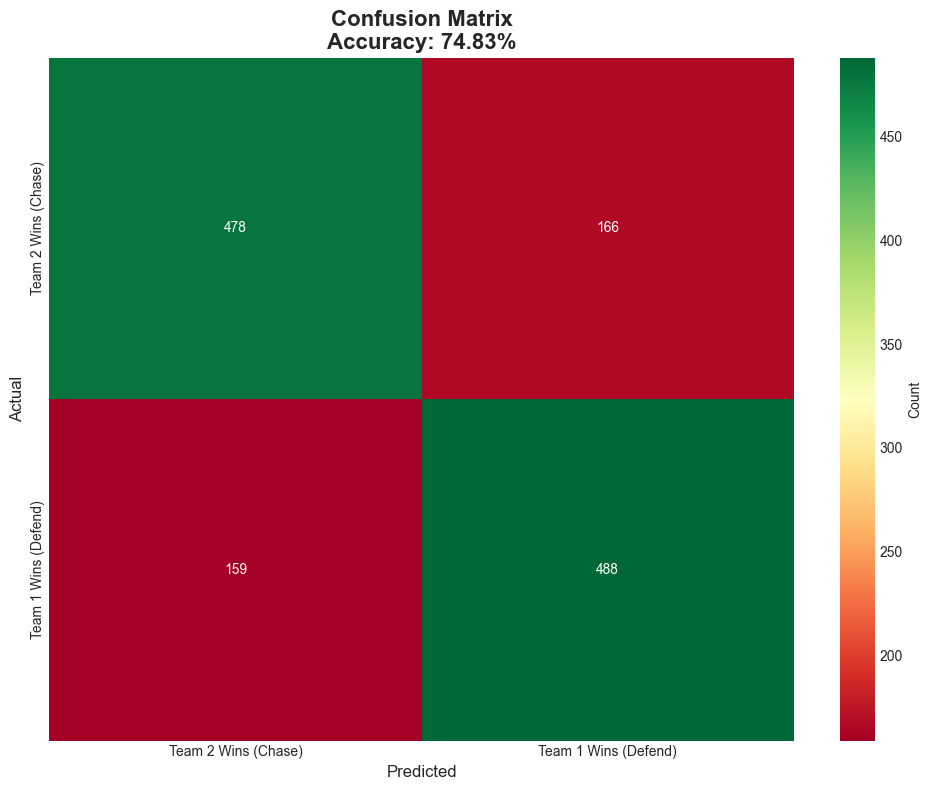

Correct Predictions: 966/1291


In [9]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', cbar_kws={'label': 'Count'},
            xticklabels=['Team 2 Wins (Chase)', 'Team 1 Wins (Defend)'],
            yticklabels=['Team 2 Wins (Chase)', 'Team 1 Wins (Defend)'])
plt.title(f'Confusion Matrix\nAccuracy: {accuracy*100:.2f}%', fontsize=16, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

print(f"Correct Predictions: {cm[0,0] + cm[1,1]}/{len(y_test)}")

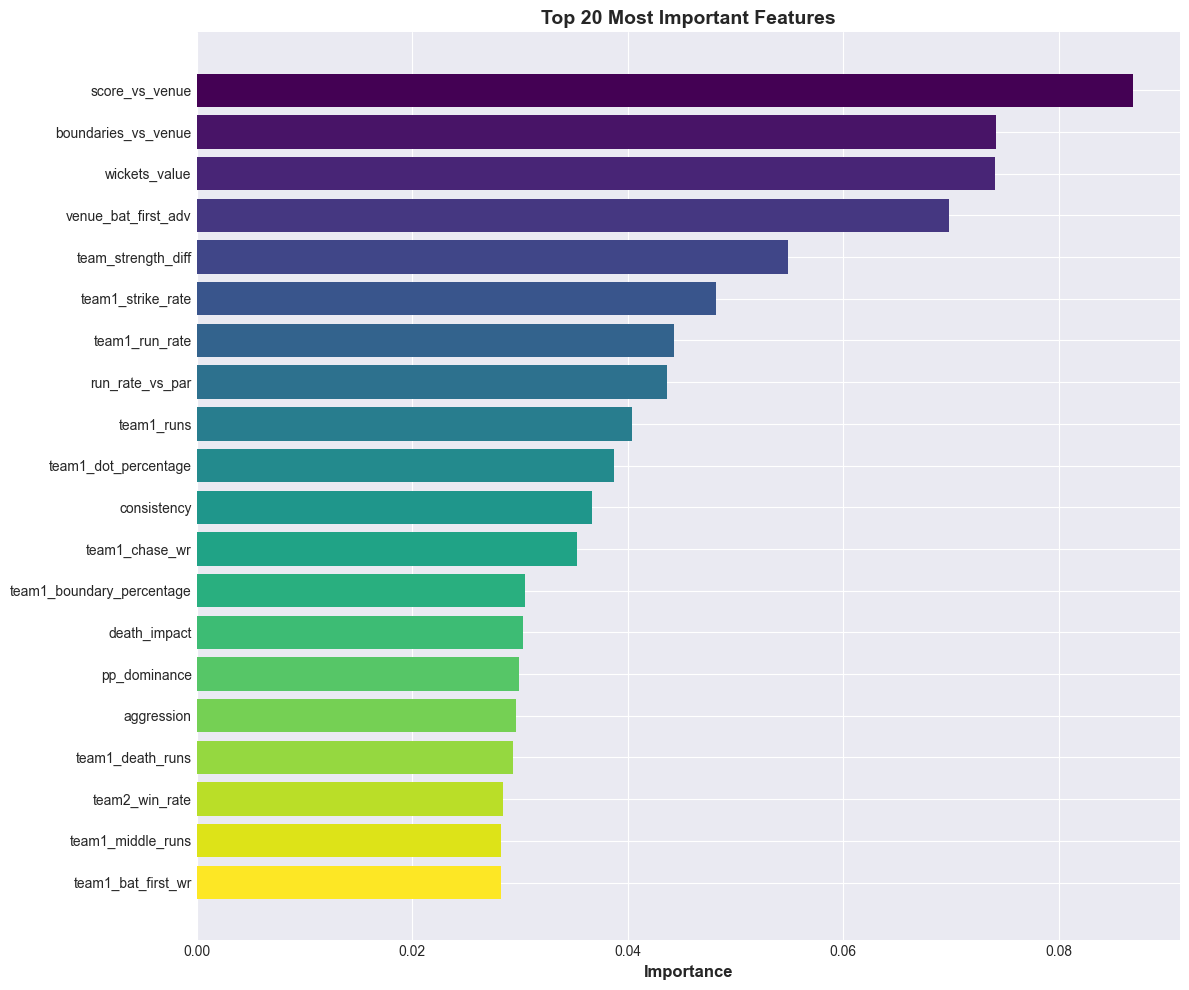


Top 10 Features:
                 feature  importance
18        score_vs_venue    0.086907
19   boundaries_vs_venue    0.074207
20         wickets_value    0.074125
17   venue_bat_first_adv    0.069783
15    team_strength_diff    0.054879
3      team1_strike_rate    0.048189
2         team1_run_rate    0.044337
23       run_rate_vs_par    0.043649
0             team1_runs    0.040416
24  team1_dot_percentage    0.038699


In [8]:
# Get feature importance from Random Forest
rf.fit(X_train, y_train)
importance = pd.DataFrame({
    'feature': features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
plt.barh(importance['feature'][:20], importance['importance'][:20], 
         color=plt.cm.viridis(np.linspace(0, 1, 20)))
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
print(importance.head(10))

SyntaxError: '{' was never closed (3090121790.py, line 42)